# Comparison NWP and observation

HARMONIE-AROME NWP data for Paris "Golden Day" case is extracted using DDH, processed to netcdf using ddh2cn (https://github.com/Abhi-smhi/ddh2nc), and compared with experimental data from the 'Urbisphere' campaign.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import zarr

In [2]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
file_exp = os.path.expandvars('$PERM/out.nc')
obs_zip_file = 'DWL_L2_data_consolidated.zarr.zip'
file_obs = Path('./data/'+obs_zip_file)
obs_url = 'https://zenodo.org/records/17950675/files/DWL_L2_data_consolidated.zarr.zip?download=1'


#1.  Download obs data zip file if not available

file_obs.parent.mkdir(parents=True, exist_ok=True)

if file_obs.exists():
    print(f"{file_obs} already exists.")
else:
    print(f"File not found. Downloading from {obs_url}...")
    # Use ! to run curl directly in the shell
    !curl -L -o {file_obs} {obs_url}
    
    if file_obs.exists():
        print("Download complete!")
    else:
        print("Download failed.")

data/DWL_L2_data_consolidated.zarr.zip already exists.


In [4]:
# 2 Read obs and NPW data

#    2.1 Explicitly use the V2 ZipStore class
if int(zarr.__version__[0]) >= 3:
    store = zarr.storage.ZipStore(file_obs, mode="r")
else:
    store = file_obs
#    2.2 Open as dataset
ds_obs = xr.open_zarr(store,consolidated=True)
ds_exp = xr.open_dataset(file_exp)

In [5]:
# Time coordinate for experiment
ds_exp = ds_exp.sortby('time')
exp_time_range = ds_exp.coords['time']
exp_time_range = (exp_time_range.min(), exp_time_range.max())
print(exp_time_range)

(<xarray.DataArray 'time' ()> Size: 8B
array('2023-08-22T03:00:05.000000000', dtype='datetime64[ns]'), <xarray.DataArray 'time' ()> Size: 8B
array('2023-08-23T03:00:00.000000000', dtype='datetime64[ns]'))


In [6]:
# Add height coordinate for experiment
Y = ds_exp.VEP1/ds_exp.VPP1/9.81 # instantaneous potential energy 
ds_exp = ds_exp.assign_coords({'height': (["time",'levels', 'domain'], Y.data)})
ds_exp.coords['height'].attrs['units'] = 'm'



In [12]:
# 3. Create subset for observational data

indices = dict(cell = ['cell_mode', 'cell_id'], 
               station = 'station_id',
               channel = ['channel_id', 'channel_mode']
              )


selection = dict(cell_mode = 0,         # 0, 1, 2  : full-level, half-level, entire-level
                 time_delta = 0,        # 0, 1     : 10-min, 60-min
                 bounds = 1,            # 0, 1     : lower-bound, upper-bound
                 channel_id = 2,        # 0, 1, 2, 3: system, station, AROME, MESO-NH
                station = 'PACHEM',    # 'PAARBO' 'PACHEM' 'PALUPD' 'PAROIS'
                time =  slice(exp_time_range[0], exp_time_range[1])
                )


ds_obs_selection = ds_obs.set_index(indices).sel(selection).isel(cell_id = slice(13, None))

Text(0.5, 1.0, 'PACHEM OBS')

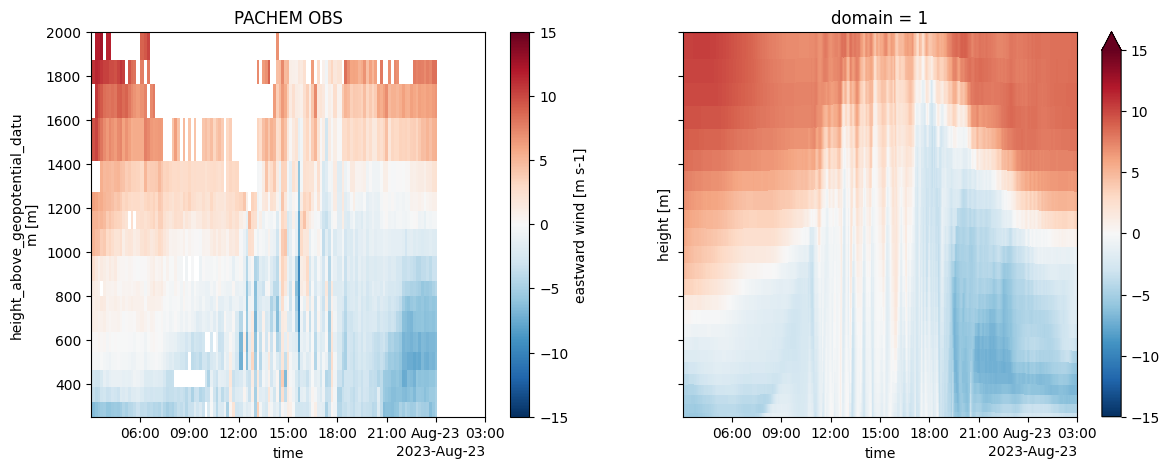

In [13]:
# Plotting

var_obs = 'u'
on_y = 'cell_z_bounds'
#on_y = 'cell_id'

var_exp = 'VUU1'
vmin = -15
vmax = 15

yincrease=True
if 'id' in on_y :
    yincrease = False
    print(yincrease)

fig, ax  = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)

ds_obs_selection[var_obs].\
    dropna('system', how = 'all').\
    dropna('channel_mode', how = 'all').\
    dropna('cell_id', how = 'all').\
    dropna('time', how = 'all').\
    plot(cmap = 'RdBu_r', 
         y = on_y,yincrease=yincrease, 
         figure=fig, ax=ax[0],
         vmin = vmin,
         vmax = vmax
        )

domain = 0 #PACHEM in DDH settings
(ds_exp[var_exp].isel(domain=domain)/ds_exp['VPP1'].isel(domain=domain))\
    .plot.pcolormesh(x = 'time', y='height',
                     cmap='RdBu_r',
                     ax=ax[1],
                     vmin = vmin,
                     vmax = vmax,
                     ylim = (250,2000)
                    )
ax[0].set_title('PACHEM OBS')
#ax[1].set_title('PACHEM NWP')


In [14]:
ds_exp['wdir1'] = np.rad2deg(np.arctan2(ds_exp['VUU1'], ds_exp['VVV1'])) + 180.

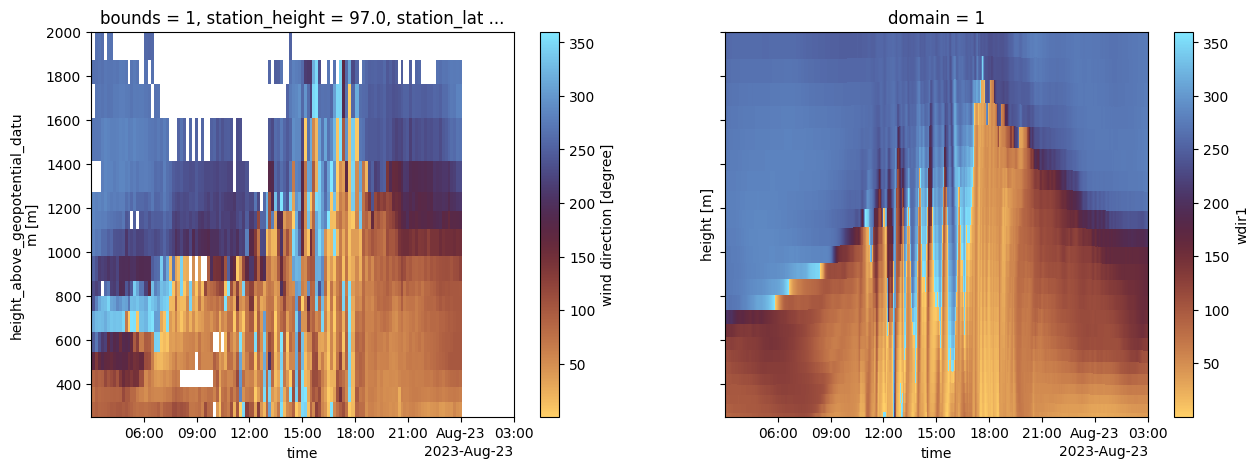

In [15]:
# Compare wdir
var_obs = 'wdir'
on_y = 'cell_z_bounds'
#on_y = 'cell_id'

var_exp = 'wdir1'
vmin = None
vmax = None
fig2, ax2 = plt.subplots(1,2,sharey=True, sharex=True, figsize=(15,5))

ds_obs_selection[var_obs].\
    dropna('system', how = 'all').\
    dropna('channel_mode', how = 'all').\
    dropna('cell_id', how = 'all').\
    dropna('time', how = 'all').\
    plot(cmap = 'managua', 
         y = on_y,yincrease=yincrease, 
         ax=ax2[0],
         vmin = vmin,
         vmax = vmax
        )

ds_exp[var_exp].isel(domain = domain).plot(x = 'time', y = 'height',
                                     cmap = 'managua',
                                     ylim = (250, 2000),
                                      ax = ax2[1]
                                    )

In [16]:
fig2.savefig('Wind_dir_arome.png')